In [45]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise import Dataset, Reader, accuracy, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from IPython.core.display import HTML

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.collocations import *
import re
import nltk

%matplotlib inline

In [26]:
user_reviews_df = pd.read_csv("./Data/user_reviews.csv")

In [3]:
# Looking at the data from the 
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598158 entries, 0 to 598157
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  598158 non-null  int64 
 1   user_id     598158 non-null  int64 
 2   recipe_id   598158 non-null  int64 
 3   date        598158 non-null  object
 4   rating      598158 non-null  int64 
 5   review      598154 non-null  object
dtypes: int64(4), object(2)
memory usage: 27.4+ MB


In [4]:
user_reviews_df.head()

,Unnamed: 0,user_id,recipe_id,date,rating,review
0,8,76535,134728,2005-09-02,4,Very good!
1,11,190375,134728,2007-03-09,5,These taste absolutely wonderful!! My son-in-...
2,12,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
3,13,255338,134728,2008-04-11,5,First time using liquid smoke in a recipe. Mad...
4,14,1171894,134728,2009-04-21,5,MMMMM! This is so good! I actually soaked the ...


In [27]:
# Drop Unnamed: 0 column
user_reviews_df.drop("Unnamed: 0", axis=1, inplace=True)
user_reviews_df

,user_id,recipe_id,date,rating,review
0,76535,134728,2005-09-02,4,Very good!
1,190375,134728,2007-03-09,5,These taste absolutely wonderful!! My son-in-...
2,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
3,255338,134728,2008-04-11,5,First time using liquid smoke in a recipe. Mad...
4,1171894,134728,2009-04-21,5,MMMMM! This is so good! I actually soaked the ...
...,...,...,...,...,...
598153,496803,249924,2011-08-21,5,I really loved this! I cut the recipe back to...
598154,143592,82303,2010-07-26,5,I will never buy hot fudge again. This is so q...
598155,140132,82303,2010-10-01,5,This is fabulous. I made it for our dessert t...
598156,199020,82303,2013-03-18,5,5 stars for taste! I had a hard time getting m...


## Visulizing Ratings

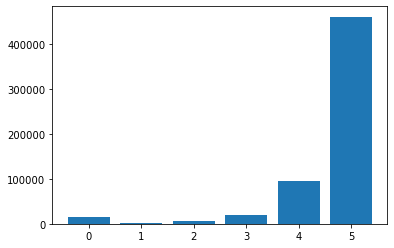

In [6]:
#Creating a bar chart to see the distribution of ratings
rating_count = user_reviews_df["rating"].value_counts().sort_index(ascending=False)

plt.bar(rating_count.index, rating_count.values);

In [8]:
# Numerical breakdown
rating_count

5    460940
4     95039
3     19168
2      5548
1      2770
0     14693
Name: rating, dtype: int64

77% of our new dataset includes 5 star reviews, which heavily skews the data and will affect the recommendation portal. 

We also notice that 2.4% of our dataset includes a 0 rating. It would be important to see if these are actually 0s or if they are imputed value for missing ratings. 

In [28]:
#Looking at the 0 ratings to see if they are actually 0s or missing ratings
user_reviews_df.loc[user_reviews_df["rating"] == 0]

,user_id,recipe_id,date,rating,review
2,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...
7,681408,225241,2008-03-14,0,This is a very good recipe. We also want to c...
19,980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot..."
205,93911,306919,2010-07-08,0,I haven't tried this recipe so I'm not rating ...
249,921361,232042,2014-10-03,0,Tasted great and was super easy to make. Thank...
...,...,...,...,...,...
597902,194886,99731,2013-01-24,0,"This is a great recipe, I thought I had review..."
597914,113509,130019,2012-04-20,0,Hubby and I thought this was good. Neither of ...
597986,374506,39724,2008-03-19,0,Great!!! After the turkey was done I browned t...
598000,329378,39902,2006-10-19,0,"While the recipe calls for 3 cups of cheese, t..."


It looks like the 0s are both a mix of positive and negative (or neutral reviews). While it is a small subset of our dataset it could be important to include these reviews considering the skew of our data. We could impute ratings based on the language used in the "review" column. To do this we will need to undertake Natural Language Processing (NLP). 

 ## Preprocessing Review Data

In [29]:
user_reviews_df["review"] = user_reviews_df["review"].astype(str)

In [35]:
# Need to remove capitalization, apostrophes, and numbers from the reviews

# Create a tokenizer that will take all words with three or more letters
pattern = r"(?u)\w{3,}"
tokenizer = RegexpTokenizer(pattern)

# Create list of stopwords in English (language of the reviews)
# Remove "very" from the list of stopwords 
stopwords_list = stopwords.words("english")
stopwords_list.remove("very")
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create an instance of nltk's WordNetLemmatizer with the variable name `lemmatizer`
lemmatizer = WordNetLemmatizer()

In [36]:
def preprocess_text(text, tokenizer, stopwords_list, lemmatizer):
    # Standardize case (lowercase the text)
    lowered_text = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lowered_text)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [word for word in tokens if word not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lemmatized_text = [lemmatizer.lemmatize(token) for token in stopped_tokens]
    
    # Return the preprocessed text
    return lemmatized_text

In [37]:
# Apply the preprocess function to the entire dataset
review_text_data = user_reviews_df.review.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmatizer))
review_text_data

0                                              [very, good]
1         [taste, absolutely, wonderful, son, law, love,...
2         [made, buttermilk, vinegar, milk, used, defros...
3         [first, time, using, liquid, smoke, recipe, ma...
4         [mmmmm, good, actually, soaked, chicken, chick...
                                ...                        
598153    [really, loved, cut, recipe, back, use, three,...
598154    [never, buy, hot, fudge, quick, easy, would, m...
598155    [fabulous, made, dessert, tonight, practically...
598156    [star, taste, hard, time, getting, mine, thick...
598157    [amazingly, delicious, change, made, cook, bit...
Name: review, Length: 598158, dtype: object

In [41]:
#Add preprocessed lemmatized text to the dataframe
user_reviews_df["preprocessed_review_text"] = review_text_data
user_reviews_df.head()

,user_id,recipe_id,date,rating,review,preprocessed_review_text
0,76535,134728,2005-09-02,4,Very good!,"[very, good]"
1,190375,134728,2007-03-09,5,These taste absolutely wonderful!! My son-in-...,"[taste, absolutely, wonderful, son, law, love,..."
2,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...,"[made, buttermilk, vinegar, milk, used, defros..."
3,255338,134728,2008-04-11,5,First time using liquid smoke in a recipe. Mad...,"[first, time, using, liquid, smoke, recipe, ma..."
4,1171894,134728,2009-04-21,5,MMMMM! This is so good! I actually soaked the ...,"[mmmmm, good, actually, soaked, chicken, chick..."


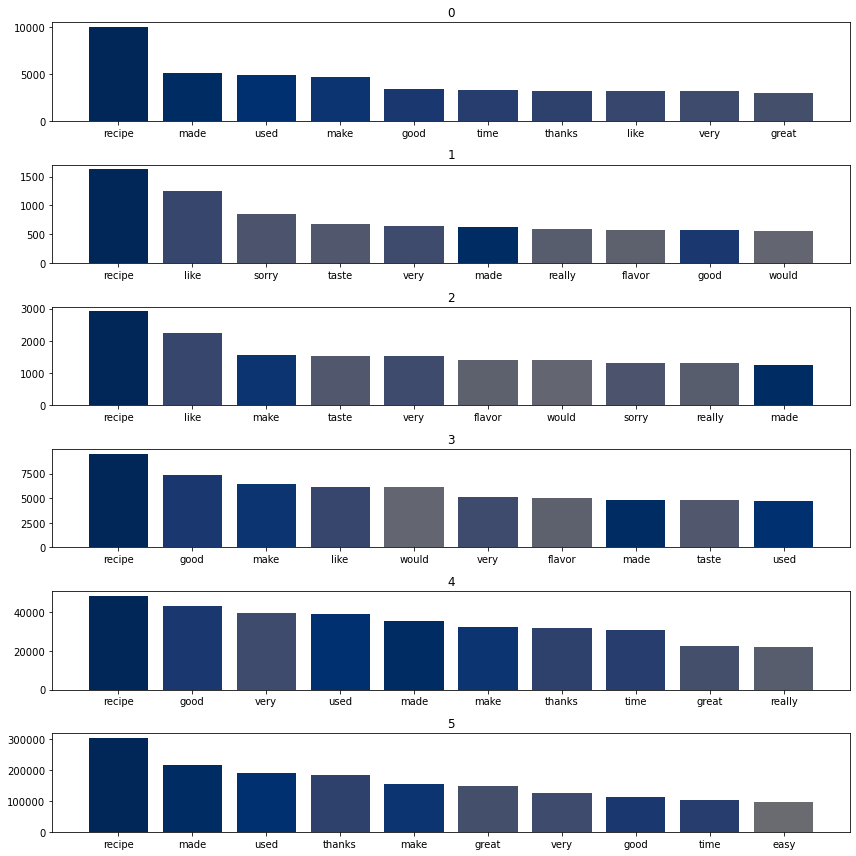

In [48]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=6, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique genre
data_by_rating = [y for _, y in user_reviews_df.groupby('rating', as_index=False)]
for idx, rating_df in enumerate(data_by_rating):
    # Find top 10 words in this genre
    all_words_in_rating = rating_df.preprocessed_review_text.explode()
    top_10 = all_words_in_rating.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(rating_df.iloc[0].rating)
    
fig.tight_layout()

In [ ]:
# Need to either make bigrams and graph those, 
# or do a frequency dist and see which words outperform in each rating category

In [40]:
# Creating Bigrams

review_text_stopped = [word for word in tokens if word not in stopwords_list]

bigram_measures = nltk.collocations.BigramAssocMeasures()

review_text_finder = BigramCollocationFinder.from_words(review_text_data)


review_text_scored = review_text_finder.score_ngrams(birgram_measures.raw_freq)

review_text_scored[:20]


TypeError: unhashable type: 'list'